Installs and imports

In [ ]:
# Install the necessary libraries
!pip install pandas requests
!pip install ydata-profiling
!pip install sweetviz
!pip install contextily geopandas
!pip install qgrid
!pip install pymannkendall

# Import libraries
import pandas as pd
import numpy as np
import math
import requests
import matplotlib.pyplot as plt
import sweetviz as sv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pymannkendall as mk

from scipy.stats import linregress
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from ydata_profiling import ProfileReport
from IPython.display import clear_output, display, HTML
from sklearn.cluster import KMeans

# Clear the console
clear_output()

Import data - Directly getting data from sql API is too big, so needs to broken into chunks.

In [ ]:
url = 'https://phl.carto.com/api/v2/sql?q=SELECT * FROM incidents_part1_part2 WHERE dispatch_date BETWEEN \'2007-01-01\' AND \'2014-12-31\''

# Send the GET request to download the data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Load the rows key into a pandas DataFrame
    df1 = pd.DataFrame(data['rows'])
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


url = 'https://phl.carto.com/api/v2/sql?q=SELECT * FROM incidents_part1_part2 WHERE dispatch_date BETWEEN \'2015-01-01\' AND \'2022-12-31\''

# Send the GET request to download the data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Load the rows key into a pandas DataFrame
    df2 = pd.DataFrame(data['rows'])
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

df = pd.concat([df1, df2], axis=0)


# Reset the index of daraframe
df.reset_index(drop=True, inplace=True)

del df1
del df2
del data
del response
del url

Functions used for analysis

In [ ]:
# Function to calculate the Haversine distance (vectorized version)
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    return r * c

def print_results(results):
  # Print the test result
  print("Test Result:")
  print(result)

  # Interpret the test results
  if result.trend == "increasing":
      print("The Mann-Kendall test detected a statistically significant increasing trend in crime rates.")
  elif result.trend == "decreasing":
      print("The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.")
  else:
      print("The Mann-Kendall test did not detect any significant trend in crime rates.")

  # Interpretation of p-value
  alpha = 0.05  # Significance level
  if result.p < alpha:
      print(f"The trend is statistically significant (p-value = {result.p:.4f} < {alpha}).")
  else:
      print(f"The trend is not statistically significant (p-value = {result.p:.4f} >= {alpha}).")

def display_plot(remaining_df,all_centers):
  # Create a GeoDataFrame from longitude and latitude
  gdf = gpd.GeoDataFrame(remaining_df, geometry=gpd.points_from_xy(remaining_df['point_x'], remaining_df['point_y']))

  # Cluster centers
  #center_df = pd.concat(center_list, ignore_index=True)

  # Create GeoDataFrame from concatenated DataFrame
  centers_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(all_centers['point_x'], all_centers['point_y']))

  # Plot
  fig, ax = plt.subplots(figsize=(5, 5))

  # Plot density using seaborn's KDE
  sns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, fill=True, cmap="Blues", alpha=0.5, ax=ax, thresh=0.05)

  # Plot points for each data point
  gdf.plot(ax=ax, color='blue', markersize=10, label='Points')

  # Plot cluster centers as red dots
  centers_gdf.plot(ax=ax, color='red', markersize=50, label='Cluster Centers')

  # Add titles and labels
  ax.set_title('Density Plot with Cluster Centers')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  ax.legend()

  plt.show()

def plot_years(yearly_counts_df):
  # List to store the sizes of each dataframe
  sizes = []
  years = range(2011, 2018)

  # Loop through the years and calculate the size (number of rows) for each year
  for i in range(7):
      sizes.append(yearly_counts_df['count'][i])

  # Create a list of colors for histogram
  colors = [
      'green' if 2010 <= year <= 2011 else
      'yellow' if 2012 <= year <= 2014 else
      'red' if 2015 <= year <= 2017 else
      'skyblue'  # Default color for other years
      for year in years
  ]

  # Plot the histogram with specified colors
  plt.figure(figsize=(8, 5))
  plt.bar(years, sizes, color=colors)
  plt.title('Number of Violent Crimes in Philadelphia from 2011 to 2017')
  plt.xlabel('Year')
  plt.ylabel('# of Violent Crimes')
  plt.xticks(years, rotation=45)
  plt.tight_layout()

  # Create a custom legend for the colors
  legend_elements = [
      plt.Line2D([0], [0], color='green', lw=4, label='First Initiative(Testing)'),
      plt.Line2D([0], [0], color='yellow', lw=4, label='Second Initiative(Incorporated changes with continued testing)'),
      plt.Line2D([0], [0], color='red', lw=4, label='Integration of smart policing'),
  ]

  plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 1.1), fontsize=10, ncol=1)
  plt.subplots_adjust(top=0.95)
  plt.show()

Data processessing

In [ ]:
# Select only the violent crimes(ucr_codes under 800)
df= df[df['ucr_general'].astype(int) < 800]

# Convert the date
df['dispatch_date'] = pd.to_datetime(df['dispatch_date'], format='%Y-%m-%d')

# add feature for year
df['year'] = pd.to_datetime(df['dispatch_date']).dt.year

# add feature for street name
df['street_name'] = df['location_block'].str.extract(r'BLOCK (.+)')

# Remove features that are not used
df = df.drop(columns=['cartodb_id','dispatch_date_time','dispatch_time','hour','objectid','dc_key','dispatch_date','dc_dist','psa','location_block','text_general_code','ucr_general'])

# Display the first 5 rows of the DataFrame in an interactive grid
df.head().style

,the_geom,the_geom_webmercator,point_x,point_y,year,street_name
0,0101000020E610000017429450F6D052C00C1997C3D1FC4340,0101000020110F0000A3F89A4F18F65FC17B0D2F015F8C5241,-75.265034,39.975151,2011,WOODCREST AV
1,0101000020E610000013038F3544D152C04F9CB3709FFC4340,0101000020110F00004C9D5D9F9CF65FC11B5B803B278C5241,-75.269788,39.973616,2011,WOODBINE AVE
2,0101000020E61000008E068DEC0CBF52C0A02FA46099064440,0101000020110F000007393990ABD75FC1CA5AEA4237975241,-74.985164,40.051556,2011,STATE RD
3,0101000020E6100000BCDA9B293EBF52C08F64E2985D064440,0101000020110F0000ABCE2E33FFD75FC11E8D4DEFF4965241,-74.988169,40.049731,2011,STATE RD
4,0101000020E6100000418FC5F4CCC852C005FF957418044440,0101000020110F0000690139533BE85FC1EEF8323F70945241,-75.137510,40.031996,2011,W WELLENS ST


The first initiative (2010-2012) was to conduct a test the effectiveness of three policing strategies; foot patrol, problem-solving, and an offender-focused strategy. The second initiative (2012-2014) incorporated the lessons learned from the first initiative, and moved from randomized experiments to an organizational change model. Philadelphia SPI's third initiative (2014-2017) continued efforts to integrate Smart Policing and analytics through the Philadelphia Police Department through use of the hypothesis testing approach. - https://www.smart-policing.com/spi-sites/philadelphia-pennsylvania-2014

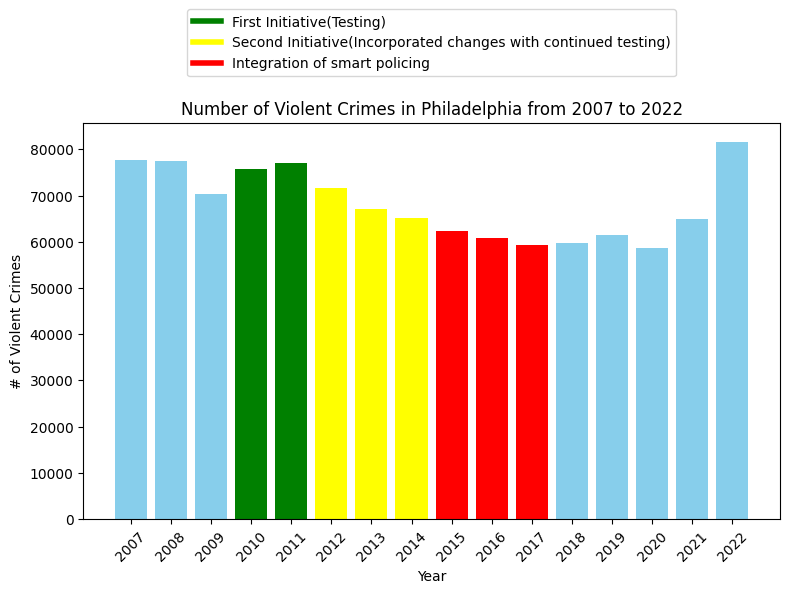

In [ ]:
# List to store the sizes of each dataframe
sizes = []

# Loop through the years and calculate the size (number of rows) for each year
years = range(2007, 2023)
for year in years:
    sizes.append(len(df[df['year'].astype(int) == year]))

# Create a list of colors for histogram
colors = [
    'green' if 2010 <= year <= 2011 else
    'yellow' if 2012 <= year <= 2014 else
    'red' if 2015 <= year <= 2017 else
    'skyblue'  # Default color for other years
    for year in years
]

# Plot the histogram with specified colors
plt.figure(figsize=(8, 5))
plt.bar(years, sizes, color=colors)
plt.title('Number of Violent Crimes in Philadelphia from 2007 to 2022')
plt.xlabel('Year')
plt.ylabel('# of Violent Crimes')
plt.xticks(years, rotation=45)
plt.tight_layout()

# Create a custom legend for the colors
legend_elements = [
    plt.Line2D([0], [0], color='green', lw=4, label='First Initiative(Testing)'),
    plt.Line2D([0], [0], color='yellow', lw=4, label='Second Initiative(Incorporated changes with continued testing)'),
    plt.Line2D([0], [0], color='red', lw=4, label='Integration of smart policing'),
]

plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 1.1), fontsize=10, ncol=1)
plt.subplots_adjust(top=0.95)
plt.show()

Line Regression Test

In [ ]:
# Select only the years 2011-2017
years_of_interest = sizes[4:11]
years = np.array([2011,2012,2013,2014,2015,2016,2017])
crime_counts = np.array(years_of_interest)

# Perform Line regression test
slope, intercept, r_value, p_value, std_err = linregress(years, crime_counts)
print(f"Slope: {slope}, P-Value: {p_value}")
print(f"R-squared: {r_value**2}")

Slope: -2829.535714285714, P-Value: 0.00033737684735605285
R-squared: 0.9376374076604131


Mann-Kendall Trend Test on all Data from 2011-2017

In [ ]:
# Perform the Mann-Kendall Trend Test
result = mk.original_test(years_of_interest)

print_results(result)

Test Result:
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0026666817936140674, z=-3.003757045930553, Tau=-1.0, s=-21.0, var_s=44.333333333333336, slope=-2681.75, intercept=73205.25)
The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.
The trend is statistically significant (p-value = 0.0027 < 0.05).


In [ ]:
# Count the number of instances for each street name and year
counts = df.groupby(["street_name", "year"]).size().reset_index(name="count")

# Pivot the dataframe to make each year a column
df_pivoted = counts.pivot(index="street_name", columns="year", values="count").reset_index()

# Replace NaN values with 0 for years with no instances
df_pivoted.fillna(0, inplace=True)

# Convert counts to integers
df_pivoted.iloc[:, 1:] = df_pivoted.iloc[:, 1:].astype(int)

# Remove years that are not of interest(2007-2009,2018-2023)
for i in range(2007, 2010):
  df_pivoted = df_pivoted.drop(columns=[i])

for i in range(2018, 2023):
  df_pivoted = df_pivoted.drop(columns=[i])

# Add a total count column to sort by total instances across all years
df_pivoted['total_count'] = df_pivoted.iloc[:, 1:].sum(axis=1)

print("Data length before removing 0 entries:",len(df_pivoted))

# Remove streets with a total count of 0
df_pivoted = df_pivoted[df_pivoted['total_count'] > 0]

# Sort the dataframe by total_count in descending order
df_sorted = df_pivoted.sort_values(by='total_count', ascending=False).drop(columns=['total_count'])

# Display the updated dataframe
df_sorted

print("Data length after removing 0 entries:",len(df_sorted))

Data length before removing 0 entries: 21533
Data length after removing 0 entries: 12593


Measured Anova Test

In [ ]:
# Prepare data for repeated measures ANOVA
anova_data = [df_sorted[year].values for year in df_sorted.columns[1:]]

# Perform the repeated measures ANOVA
f_stat, p_value = f_oneway(*anova_data)

# Display the results
print(f"F-Statistic: {f_stat}")
print(f"P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The difference in counts across years is statistically significant.")
else:
    print("The difference in counts across years is not statistically significant.")


F-Statistic: 2.507727832443693
P-Value: 0.014158071554895636
The difference in counts across years is statistically significant.


Find hot spot streets used z-test

In [ ]:
# Create a new dataframe with total counts for each street
df_total_counts = df_sorted.copy()

# Add a column for total counts across all years
df_total_counts['total_count'] = df_total_counts.iloc[:, 1:].sum(axis=1)

# Retain only the street name and total count columns
df_total_counts = df_total_counts[['street_name', 'total_count']]

# Calculate z-scores for total counts
mean_total = df_total_counts['total_count'].mean()
std_total = df_total_counts['total_count'].std()
df_total_counts['z_score'] = (df_total_counts['total_count'] - mean_total) / std_total

# Define a threshold for "hot spots" (e.g., z > 1.5)
z_threshold = 0.5
hot_spots = df_total_counts[df_total_counts['z_score'] >= z_threshold]

print("Hot Spot Streets (Based on Z-Score):")
print(hot_spots)
print("Number of Hot spot streets:",len(hot_spots))
print("Total number of streets:",len(df_total_counts))

print("Percent of streets that are considered hot spots:",100*len(hot_spots)/len(df_total_counts),"%")

# select only hot spot streets
top_streets = len(hot_spots)
hot_spot_per_year = df_sorted[0:top_streets]


Hot Spot Streets (Based on Z-Score):
year        street_name  total_count    z_score
11944        N BROAD ST      10289.0  44.362576
9926          MARKET ST       9855.0  42.483981
5086   E ROOSEVELT BLVD       8358.0  36.004123
2680        CHESTNUT ST       6978.0  30.030707
20437         WALNUT ST       6461.0  27.792841
...                 ...          ...        ...
18285        TREMONT ST        157.0   0.505586
4634        E HAGERT ST        156.0   0.501257
7618       HARTVILLE ST        156.0   0.501257
21517          YOCUM ST        156.0   0.501257
9002       LARCHWOOD AV        156.0   0.501257

[733 rows x 3 columns]
Number of Hot spot streets: 733
Total number of streets: 12593
Percent of streets that are considered hot spots: 5.820694036369412 %


Measured Anova Test for Hot Spot Streets based on Z-score of 0.5

In [ ]:
# Prepare data for repeated measures ANOVA
anova_data = [hot_spot_per_year[year].values for year in hot_spot_per_year.columns[1:]]

# Perform the repeated measures ANOVA
f_stat, p_value = f_oneway(*anova_data)

# Display the results
print(f"F-Statistic: {f_stat}")
print(f"P-Value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The difference in counts across years is statistically significant.")
else:
    print("The difference in counts across years is not statistically significant.")


F-Statistic: 2.0579189881199462
P-Value: 0.04460315557587483
The difference in counts across years is statistically significant.


Remove years 2018-2022

In [ ]:
df_pivoted = df.copy()
for year in range(2018, 2023):
    df_pivoted = df_pivoted[df_pivoted['year'] != year]

# Reset the index after dropping rows
df_pivoted = df_pivoted.reset_index(drop=True)

Find first hot spot cluster using k-means clustering

In [ ]:
kmeans = KMeans(n_clusters=1, random_state=42)

df_kmeans = df.copy()

# Remove years 2018-2022
for year in range(2018, 2023):
    df_kmeans = df_kmeans[df_kmeans['year'] != year]

# Remove NA entries
df_cleaned = df_kmeans.dropna(subset=['point_x', 'point_y'])
og_size = len(df_cleaned)

# Fit model and add cluster labels
kmeans.fit(df_cleaned[['point_x', 'point_y']])
df_cleaned['cluster'] = kmeans.labels_

# Get the centers
centers1 = pd.DataFrame(kmeans.cluster_centers_, columns=['point_x', 'point_y'])

clear_output()

# Display the cluster centers and the updated dataframe
print("Cluster Centers:")
print(centers1)

df_cleaned = df_cleaned.copy()

# Map cluster center coordinates to the dataframe
df_cleaned.loc[:, 'center_lat'] = df_cleaned['cluster'].map(centers1['point_y'])
df_cleaned.loc[:, 'center_lon'] = df_cleaned['cluster'].map(centers1['point_x'])

# Apply the vectorized Haversine formula
df_cleaned.loc[:, 'radius'] = haversine_vectorized(
    df_cleaned['point_y'], df_cleaned['point_x'],
    df_cleaned['center_lat'], df_cleaned['center_lon']
)

# Drop temporary columns for centers
df_cleaned = df_cleaned.drop(columns=['center_lat', 'center_lon'])

# Perform z-test to get closest points to center for hot spot
radius_mean = df_cleaned['radius'].mean()
radius_std = df_cleaned['radius'].std()

z_value = -1.3
threshold = radius_mean + (z_value * radius_std)

filtered_df = df_cleaned[df_cleaned['radius'] <= threshold]
remaining_df = df_cleaned[df_cleaned['radius'] > threshold]


print("\nPercent filtered:",100*len(filtered_df)/og_size,"%")
#print(len(filtered_df),len(remaining_df),len(filtered_df)+len(remaining_df),og_size)

Cluster Centers:
     point_x    point_y
0 -75.147166  39.992566

Percent filtered: 6.820446552275392 %


Perform Mann-Kendall test

In [ ]:
# Remove years 2007-1010
for year in range(2007, 2011):
    filtered_df = filtered_df[filtered_df['year'] != year]

yearly_counts = filtered_df['year'].value_counts().sort_index()
yearly_counts_df = yearly_counts.reset_index()
yearly_counts_df.columns = ['year', 'count']

#print(yearly_counts_df)

result = mk.original_test(yearly_counts_df['count'])

print_results(result)

Test Result:
Mann_Kendall_Test(trend='decreasing', h=True, p=0.00686379498544909, z=-2.7033813413374976, Tau=-0.9047619047619048, s=-19.0, var_s=44.333333333333336, slope=-163.5, intercept=5057.5)
The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.
The trend is statistically significant (p-value = 0.0069 < 0.05).


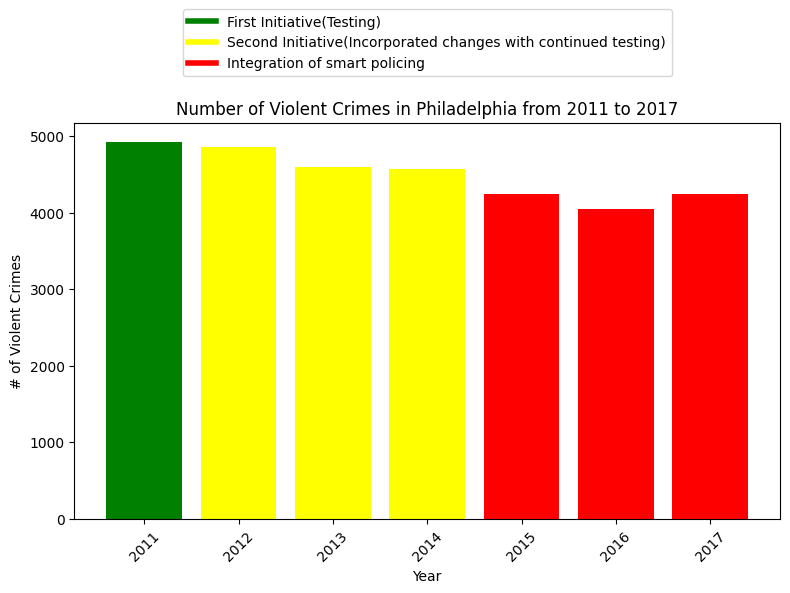

In [ ]:
plot_years(yearly_counts_df)

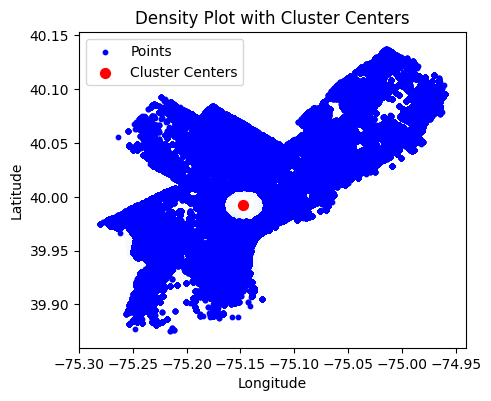

In [ ]:
display_plot(remaining_df,centers1)

Find next two hot spot clusters using k-means

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)

df_kmeans = remaining_df.copy()

for year in range(2018, 2023):
    df_kmeans = df_kmeans[df_kmeans['year'] != year]

df_cleaned = df_kmeans.dropna(subset=['point_x', 'point_y'])

# Reset the index after dropping rows
df_cleaned = df_cleaned.reset_index(drop=True)

# Fit model and get centers
kmeans.fit(df_cleaned[['point_x', 'point_y']])
df_cleaned['cluster'] = kmeans.labels_

# Extract cluster centers
centers2 = pd.DataFrame(kmeans.cluster_centers_, columns=['point_x', 'point_y'])

# Display the cluster centers and the updated dataframe
print("Cluster Centers:")
print(centers2)

Cluster Centers:
     point_x    point_y
0 -75.188066  39.961753
1 -75.092052  40.033973


In [ ]:
og_size = len(remaining_df)

# Ensure df_cleaned is an independent copy
df_cleaned = df_cleaned.copy()

df0 = df_cleaned[df_cleaned['cluster'] == 0]
df1 = df_cleaned[df_cleaned['cluster'] == 1]


# Map cluster center coordinates to the dataframe
df0.loc[:, 'center_lat'] = df0['cluster'].map(centers2['point_y'])
df0.loc[:, 'center_lon'] = df0['cluster'].map(centers2['point_x'])

df1.loc[:, 'center_lat'] = df1['cluster'].map(centers2['point_y'])
df1.loc[:, 'center_lon'] = df1['cluster'].map(centers2['point_x'])

# Apply the vectorized Haversine formula
df0.loc[:, 'radius'] = haversine_vectorized(
    df0['point_y'], df0['point_x'],
    df0['center_lat'], df0['center_lon']
)

# Apply the vectorized Haversine formula
df1.loc[:, 'radius'] = haversine_vectorized(
    df1['point_y'], df1['point_x'],
    df1['center_lat'], df1['center_lon']
)

# Drop temporary columns for centers
df0 = df0.drop(columns=['center_lat', 'center_lon'])
df1 = df1.drop(columns=['center_lat', 'center_lon'])


# Calculate the mean and standard deviation of the radius
radius_mean0 = df0['radius'].mean()
radius_std0 = df0['radius'].std()

radius_mean1 = df1['radius'].mean()
radius_std1 = df1['radius'].std()

# Calculate the z threshold
z_value = -1.15 # Z value threshold
threshold0 = radius_mean0 + (z_value * radius_std0)
threshold1 = radius_mean1 + (z_value * radius_std1)



# Filter entries where the radius is below the z threshold
filtered_df0 = df0[df0['radius'] <= threshold0]
remaining_df0 = df0[df0['radius'] > threshold0]

filtered_df1 = df1[df1['radius'] <= threshold1]
remaining_df1 = df1[df1['radius'] > threshold1]

clear_output()

print("Percent of data in first hot spot cluster:",100*len(filtered_df0)/og_size,"%")

#print(len(filtered_df0),len(remaining_df0),len(filtered_df0)+len(remaining_df0),og_size)

print("Percent of data in second hot spot cluster:",100*len(filtered_df1)/og_size,"%")

#print(len(filtered_df1),len(remaining_df1),len(filtered_df1)+len(remaining_df1),og_size)

Percent of data in first hot spot cluster: 4.797245808450438 %
Percent of data in second hot spot cluster: 3.96715672327838 %


In [ ]:
for year in range(2007, 2011):
    filtered_df0 = filtered_df0[filtered_df0['year'] != year]
    filtered_df1 = filtered_df1[filtered_df1['year'] != year]

  # Count the number of entries per year in the dataframe
yearly_counts0 = filtered_df0['year'].value_counts().sort_index()
yearly_counts1 = filtered_df1['year'].value_counts().sort_index()

# Convert the result to a DataFrame for better readability
yearly_counts_df0 = yearly_counts0.reset_index()
yearly_counts_df0.columns = ['year', 'count']

# Display the DataFrame with counts per year
#print(yearly_counts_df0)

yearly_counts_df1 = yearly_counts1.reset_index()
yearly_counts_df1.columns = ['year', 'count']

#print(yearly_counts_df1)

In [ ]:
# Perform the Mann-Kendall Trend Test
result = mk.original_test(yearly_counts_df0['count'])

print_results(result)

Test Result:
Mann_Kendall_Test(trend='decreasing', h=True, p=0.035498131320662596, z=-2.102629932151387, Tau=-0.7142857142857143, s=-15.0, var_s=44.333333333333336, slope=-113.66666666666667, intercept=3320.0)
The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.
The trend is statistically significant (p-value = 0.0355 < 0.05).


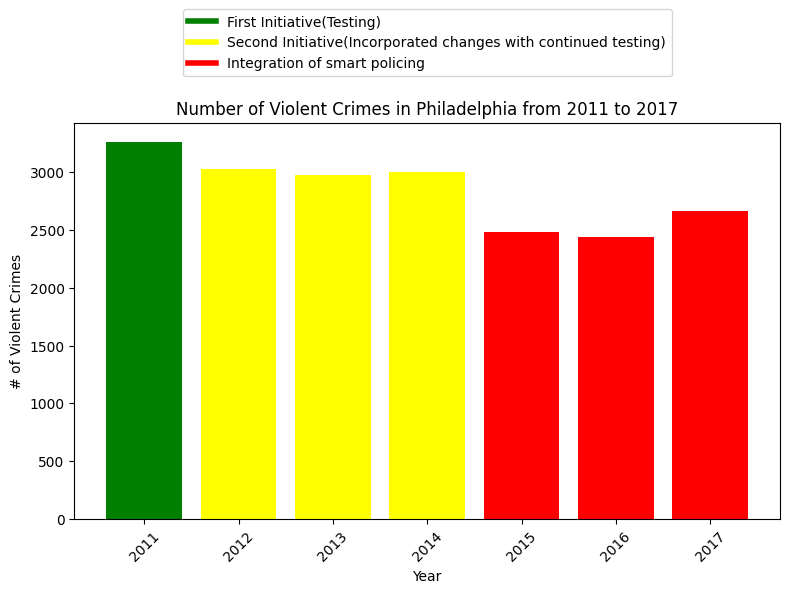

In [ ]:
plot_years(yearly_counts_df0)

In [ ]:
# Perform the Mann-Kendall Trend Test
result = mk.original_test(yearly_counts_df1['count'])

print_results(result)

Test Result:
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0026666817936140674, z=-3.003757045930553, Tau=-1.0, s=-21.0, var_s=44.333333333333336, slope=-161.0, intercept=3008.0)
The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.
The trend is statistically significant (p-value = 0.0027 < 0.05).


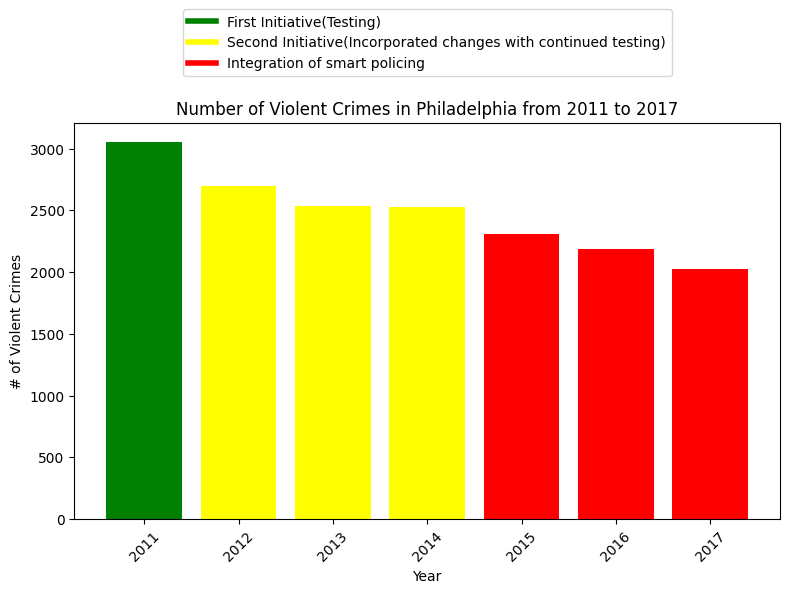

In [ ]:
plot_years(yearly_counts_df1)

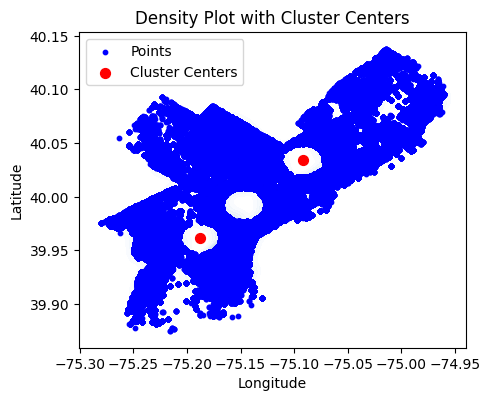

In [ ]:
remaining_df = pd.concat([remaining_df0, remaining_df1], ignore_index=True)

display_plot(remaining_df,centers2)

In [ ]:
#remaning_df = pd.concat([remaining_df0, remaining_df1], ignore_index=True)

kmeans = KMeans(n_clusters=3, random_state=42)

df_kmeans = remaining_df.copy()

for year in range(2018, 2023):
    df_kmeans = df_kmeans[df_kmeans['year'] != year]

df_cleaned = df_kmeans.dropna(subset=['point_x', 'point_y'])

# Reset the index after dropping rows
#df_cleaned = df_cleaned.reset_index(drop=True)

kmeans.fit(df_cleaned[['point_x', 'point_y']])

df_cleaned['cluster'] = kmeans.labels_

# Extract cluster centers
centers3 = pd.DataFrame(kmeans.cluster_centers_, columns=['point_x', 'point_y'])


# Display the cluster centers and the updated dataframe
print("Cluster Centers:")
print(centers3)

Cluster Centers:
     point_x    point_y
0 -75.145695  40.017250
1 -75.043680  40.050967
2 -75.192002  39.947541


In [ ]:
og_size = len(remaining_df)

import numpy as np

# Ensure df_cleaned is an independent copy
df_cleaned = df_cleaned.copy()

df0 = df_cleaned[df_cleaned['cluster'] == 0]
df1 = df_cleaned[df_cleaned['cluster'] == 1]
df2 = df_cleaned[df_cleaned['cluster'] == 2]


# Map cluster center coordinates to the dataframe
df0.loc[:, 'center_lat'] = df0['cluster'].map(centers3['point_y'])
df0.loc[:, 'center_lon'] = df0['cluster'].map(centers3['point_x'])

df1.loc[:, 'center_lat'] = df1['cluster'].map(centers3['point_y'])
df1.loc[:, 'center_lon'] = df1['cluster'].map(centers3['point_x'])

df2.loc[:, 'center_lat'] = df2['cluster'].map(centers3['point_y'])
df2.loc[:, 'center_lon'] = df2['cluster'].map(centers3['point_x'])

# Apply the vectorized Haversine formula
df0.loc[:, 'radius'] = haversine_vectorized(
    df0['point_y'], df0['point_x'],
    df0['center_lat'], df0['center_lon']
)

# Apply the vectorized Haversine formula
df1.loc[:, 'radius'] = haversine_vectorized(
    df1['point_y'], df1['point_x'],
    df1['center_lat'], df1['center_lon']
)

# Apply the vectorized Haversine formula
df2.loc[:, 'radius'] = haversine_vectorized(
    df2['point_y'], df2['point_x'],
    df2['center_lat'], df2['center_lon']
)

# Drop temporary columns for centers
df0 = df0.drop(columns=['center_lat', 'center_lon'])
df1 = df1.drop(columns=['center_lat', 'center_lon'])
df2 = df2.drop(columns=['center_lat', 'center_lon'])


# Calculate the mean and standard deviation of the radius
radius_mean0 = df0['radius'].mean()
radius_std0 = df0['radius'].std()

radius_mean1 = df1['radius'].mean()
radius_std1 = df1['radius'].std()

radius_mean2 = df2['radius'].mean()
radius_std2 = df2['radius'].std()

# Calculate the z threshold
z_value = -1 # Z value threshold
threshold0 = radius_mean0 + (z_value * radius_std0)
threshold1 = radius_mean1 + (z_value * radius_std1)
threshold2 = radius_mean2 + (z_value * radius_std2)



# Filter entries where the radius is below the z threshold
filtered_df0 = df0[df0['radius'] <= threshold0]
remaining_df0 = df0[df0['radius'] > threshold0]

filtered_df1 = df1[df1['radius'] <= threshold1]
remaining_df1 = df1[df1['radius'] > threshold1]

filtered_df2 = df2[df2['radius'] <= threshold2]
remaining_df2 = df2[df2['radius'] > threshold2]

clear_output()

#print(filtered_df0[['street_name', 'point_x', 'point_y', 'cluster', 'radius','year']])
print("Percent of data in first hot spot cluster:",100*len(filtered_df0)/og_size,"%")

#print(len(filtered_df0),len(remaining_df0),len(filtered_df0)+len(remaining_df0),og_size)


print("Percent of data in second hot spot cluster:",100*len(filtered_df1)/og_size,"%")

#print(len(filtered_df1),len(remaining_df1),len(filtered_df1)+len(remaining_df1),og_size)

print("Percent of data in third hot spot cluster:",100*len(filtered_df2)/og_size,"%")

#print(len(filtered_df2),len(remaining_df2),len(filtered_df2)+len(remaining_df2),og_size)

Percent of data in first hot spot cluster: 6.121844545327757 %
Percent of data in second hot spot cluster: 2.9788087585658967 %
Percent of data in third hot spot cluster: 7.13447341574981 %


In [ ]:
for year in range(2007, 2011):
    filtered_df0 = filtered_df0[filtered_df0['year'] != year]
    filtered_df1 = filtered_df1[filtered_df1['year'] != year]
    filtered_df2 = filtered_df2[filtered_df2['year'] != year]


  # Count the number of entries per year in the dataframe
yearly_counts0 = filtered_df0['year'].value_counts().sort_index()
yearly_counts1 = filtered_df1['year'].value_counts().sort_index()
yearly_counts2 = filtered_df2['year'].value_counts().sort_index()


# Convert the result to a DataFrame for better readability
yearly_counts_df0 = yearly_counts0.reset_index()
yearly_counts_df0.columns = ['year', 'count']

# Display the DataFrame with counts per year
#print(yearly_counts_df0)

yearly_counts_df1 = yearly_counts1.reset_index()
yearly_counts_df1.columns = ['year', 'count']

#print(yearly_counts_df1)

yearly_counts_df2 = yearly_counts2.reset_index()
yearly_counts_df2.columns = ['year', 'count']

#print(yearly_counts_df2)

In [ ]:
# Perform the Mann-Kendall Trend Test
result = mk.original_test(yearly_counts_df0['count'])

print_results(result)

Test Result:
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0026666817936140674, z=-3.003757045930553, Tau=-1.0, s=-21.0, var_s=44.333333333333336, slope=-137.0, intercept=3789.0)
The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.
The trend is statistically significant (p-value = 0.0027 < 0.05).


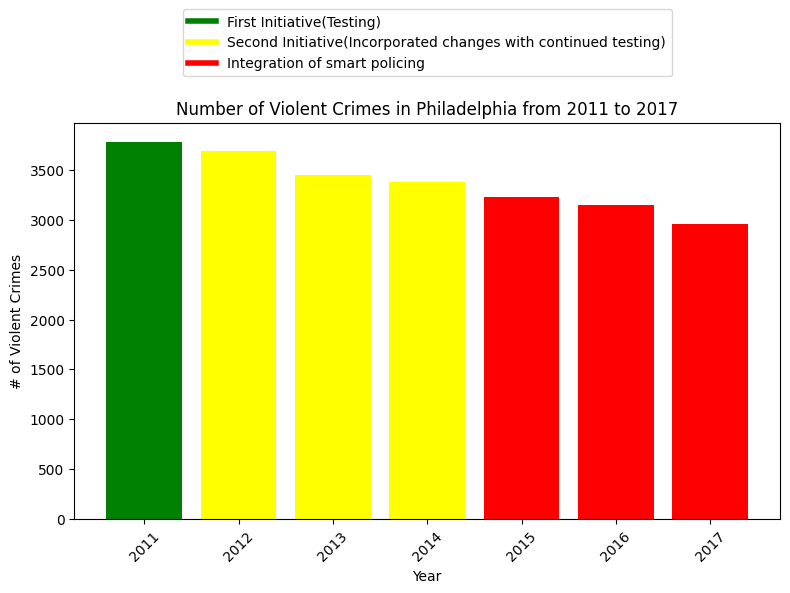

In [ ]:
plot_years(yearly_counts_df0)

In [ ]:
# Perform the Mann-Kendall Trend Test
result = mk.original_test(yearly_counts_df1['count'])

print_results(result)

Test Result:
Mann_Kendall_Test(trend='decreasing', h=True, p=0.04828610767668162, z=-1.9748417658131499, Tau=-0.6666666666666666, s=-14.0, var_s=43.333333333333336, slope=-61.8, intercept=1863.4)
The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.
The trend is statistically significant (p-value = 0.0483 < 0.05).


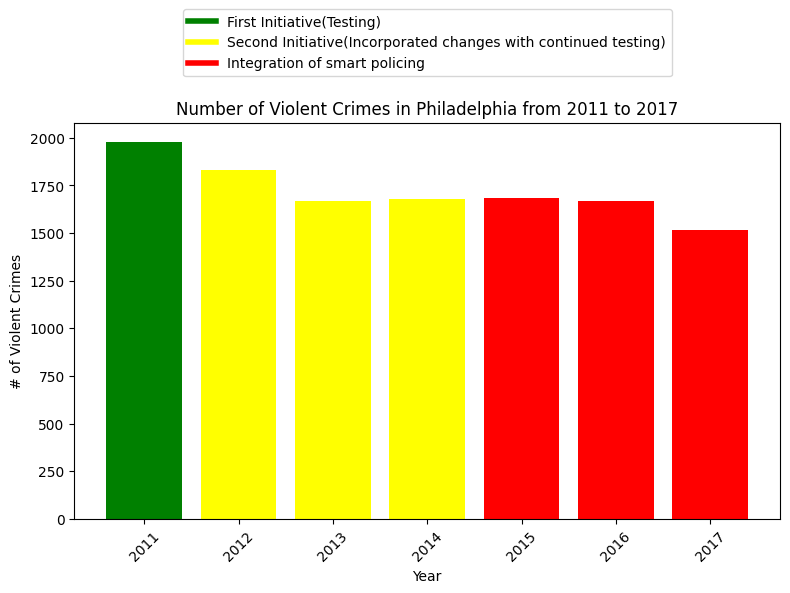

In [ ]:
plot_years(yearly_counts_df1)

In [ ]:
# Perform the Mann-Kendall Trend Test
result = mk.original_test(yearly_counts_df2['count'])

print_results(result)

Test Result:
Mann_Kendall_Test(trend='decreasing', h=True, p=0.016260936780450264, z=-2.4030056367444423, Tau=-0.8095238095238095, s=-17.0, var_s=44.333333333333336, slope=-221.0, intercept=4273.0)
The Mann-Kendall test detected a statistically significant decreasing trend in crime rates.
The trend is statistically significant (p-value = 0.0163 < 0.05).


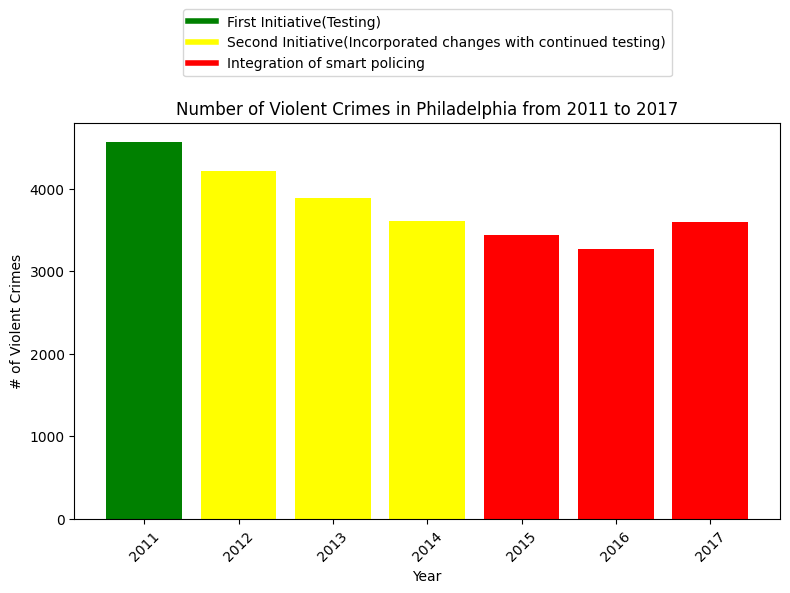

In [ ]:
plot_years(yearly_counts_df2)

In [ ]:
centers2 = centers2.rename(index={0: 2})
centers3 = centers3.rename(index={0: 3})
centers3 = centers3.rename(index={1: 4})
centers3 = centers3.rename(index={2: 5})

print(centers1)
print("\n",centers2)
print("\n",centers3)
combined_centers = pd.concat([centers1, centers2], ignore_index=False)
all_centers = pd.concat([combined_centers, centers3], ignore_index=False)
print("\n",all_centers)

     point_x    point_y
0 -75.147166  39.992566

      point_x    point_y
2 -75.188066  39.961753
1 -75.092052  40.033973

      point_x    point_y
3 -75.145695  40.017250
4 -75.043680  40.050967
5 -75.192002  39.947541

      point_x    point_y
0 -75.147166  39.992566
2 -75.188066  39.961753
1 -75.092052  40.033973
3 -75.145695  40.017250
4 -75.043680  40.050967
5 -75.192002  39.947541


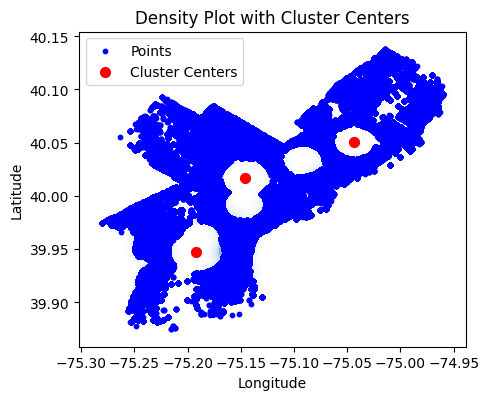

In [ ]:
remaining_df_temp = pd.concat([remaining_df0, remaining_df1], ignore_index=True)
remaining_df = pd.concat([remaining_df_temp, remaining_df2], ignore_index=True)

display_plot(remaining_df,centers3)

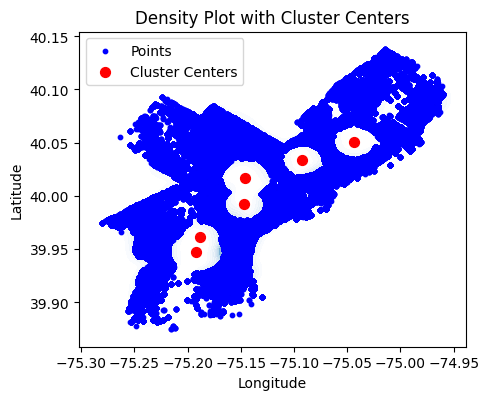

In [ ]:
display_plot(remaining_df,all_centers)